## Outlier Engineering


An outlier is a data point which is significantly different from the remaining data. “An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Statistics such as the mean and variance are very susceptible to outliers. In addition, **some Machine Learning models are sensitive to outliers** which may decrease their performance. Thus, depending on which algorithm we wish to train, we often remove outliers from our variables.

We discussed in section 3 of this course how to identify outliers. In this section, we we discuss how we can process them to train our machine learning models.


## How can we pre-process outliers?

- Trimming: remove the outliers from our dataset
- Treat outliers as missing data, and proceed with any missing data imputation technique
- Discrestisation: outliers are placed in border bins together with higher or lower values of the distribution
- Censoring: capping the variable distribution at a max and / or minimum value

**Censoring** is also known as:

- top and bottom coding
- winsorization
- capping


## Censoring or Capping.

**Censoring**, or **capping**, means capping the maximum and /or minimum of a distribution at an arbitrary value. 
On other words, values bigger or smaller than the arbitrarily determined ones are **censored**.

Capping can be done at both tails, or just one of the tails, depending on the variable and the user.

Check [pydata](https://www.youtube.com/watch?v=KHGGlozsRtA), by Soledad Galli, for an example of capping used 
in a finance company.

The numbers at which to cap the distribution can be determined:

- arbitrarily
- using the inter-quantal range proximity rule
- using the gaussian approximation
- using quantiles


### Advantages

- does not remove data

### Limitations

- distorts the distributions of the variables
- distorts the relationships among variables


## In this Demo

We will see how to perform capping with the gaussian approximation

## Important

When doing capping, we tend to cap values both in train and test set. It is important to remember that the capping values MUST be derived from the train set. And then use those same values to cap the variables in the test set

I will not do that in this demo, but please keep that in mind when setting up your pipelines

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

from feature_engine.outlier_removers import Winsorizer

3.DATASET
The dataset for this paper has been obtained 
from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Automobile).

This data set consists of three types of entities: (a) the specification of an auto in terms of various 
characteristics, (b)its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.

The second rating corresponds to the degree to which the auto is more risky than its price indicates.
Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky 
(or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process 
“symboling”. A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year. This value is normalized 
for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc…),
and represents the average loss per car per year.

There are total 205 instances and 26 attributes out of which 15 are continuous, 1 is integer and 
10 are nominal. There are missing values as well.

In [2]:
# let's load the imports-85-clean-data.csv dataset

data = pd.read_csv('C:\\Users\\gusal\\machine learning\\Feature engineering\\automobile data set\\imports-85-clean-data.csv')


In [3]:
# let's inspect the first 5 rows
data

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,128.414508,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27,13495.0
1,3,128.414508,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000.0,21,27,16500.0
2,1,128.414508,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500.0,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.000000,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400.0,23,28,16845.0
201,-1,95.000000,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300.0,19,25,19045.0
202,-1,95.000000,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500.0,18,23,21485.0
203,-1,95.000000,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800.0,26,27,22470.0


In [4]:
data.describe()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,128.576317,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.324878,3.253366,10.142537,104.848780,5125.369458,25.219512,30.751220,13321.278623
std,1.245307,38.606463,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.273049,0.313937,3.972040,39.969861,476.979093,6.542142,6.886443,8095.996440
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,95.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.130000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,125.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,154.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,120.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [5]:
# find numerical variables
# those different from object and also excluding the target Price
features_numerical = [c for c in data.columns if data[c].dtypes!='O']

In [6]:
features_numerical

['symboling',
 'normalized-losses',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-size',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'price']

In [7]:
# function to create histogram, Q-Q plot and
# boxplot. We learned this in section 3 of the course


def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [8]:

### Skewed variables

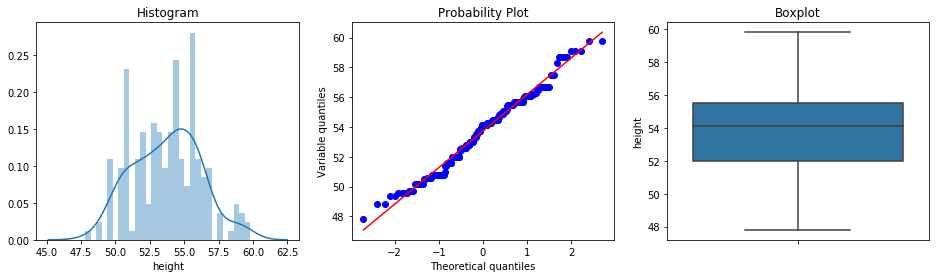

In [9]:
# let's start with the variable height from the
# automobile dataset.

diagnostic_plots(data, 'height')

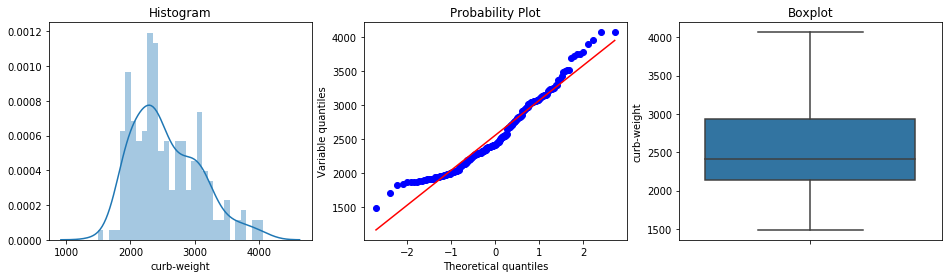

In [10]:

diagnostic_plots(data, 'curb-weight')

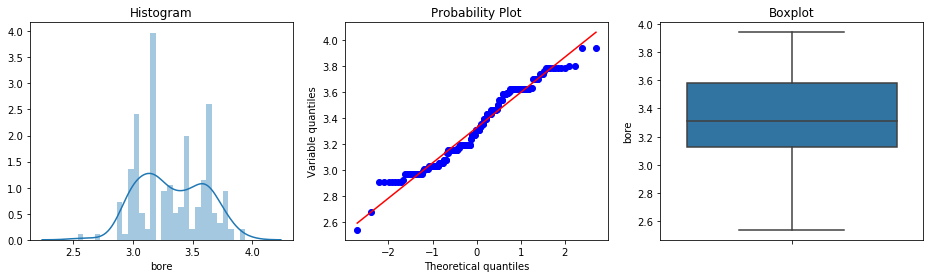

In [11]:
diagnostic_plots(data, 'bore')

### There are not outliers for the variables 'bore', 'curb-weight' and 'height' according to the boxplot.

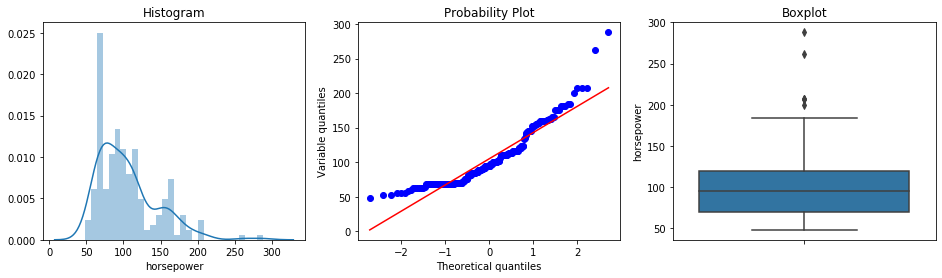

In [12]:
diagnostic_plots(data, 'horsepower')

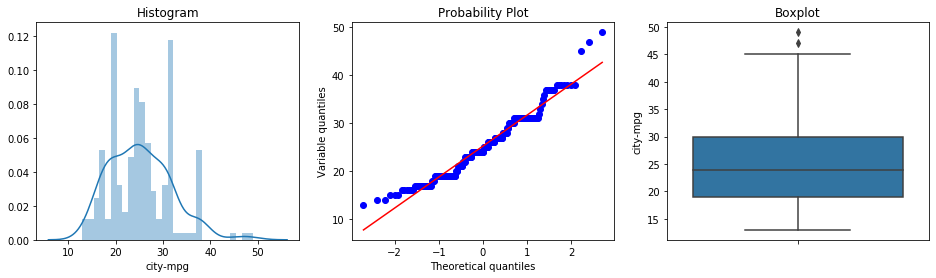

In [13]:
diagnostic_plots(data, 'city-mpg')

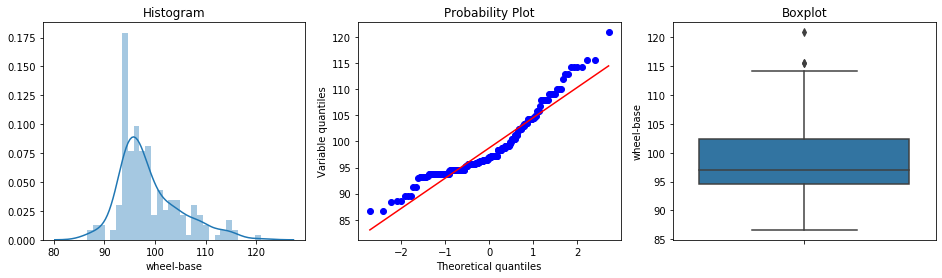

In [14]:
diagnostic_plots(data, 'wheel-base')

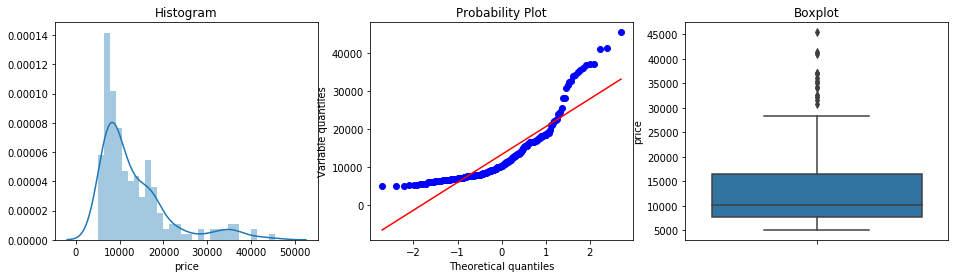

In [15]:
diagnostic_plots(data, 'price')

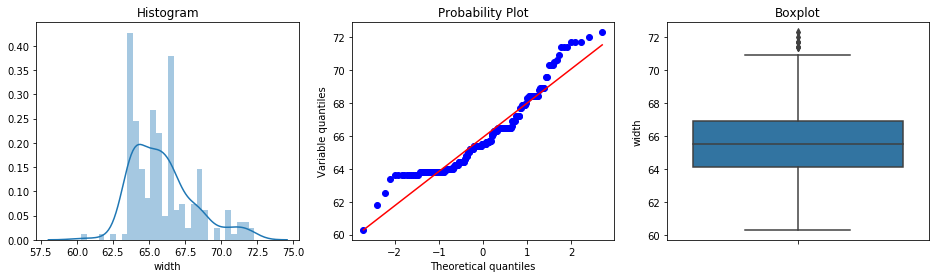

In [16]:
diagnostic_plots(data, 'width')

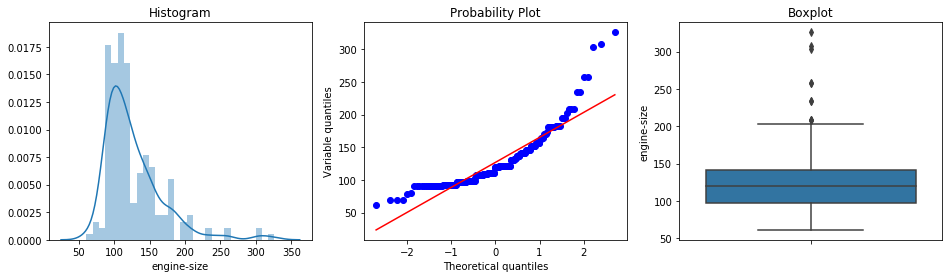

In [17]:
diagnostic_plots(data, 'engine-size')

In [18]:
### the graphics show some unusual values at the right end of its distribution for the variables 'normalized-losses', 
###'peak-rpm' ,'highway-mpg', 'horsepower', 'city-mpg', 'wheel-base', 'price', 'width','engine-size'  
### according to the boxplot.

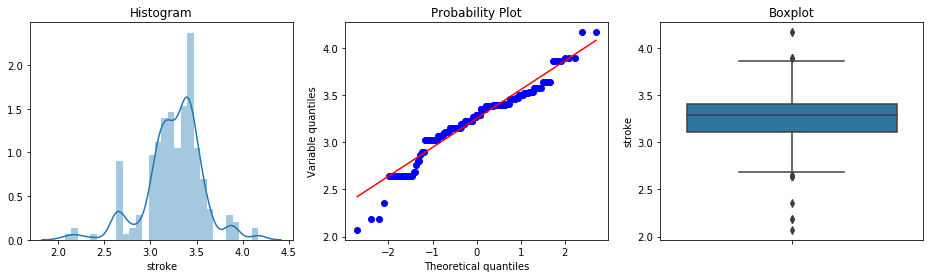

In [19]:
diagnostic_plots(data, 'stroke')

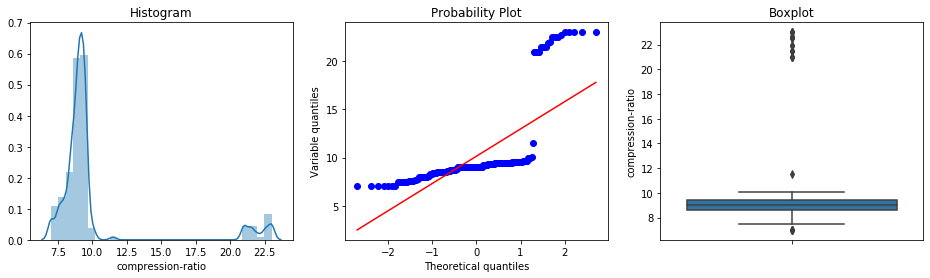

In [20]:
diagnostic_plots(data, 'compression-ratio')

In [21]:
### shows some unusual values at the left and right end of its distribution for the variables 
###'stroke' and 'compression-ratio' 
### according to the boxplot.

In [22]:
def find_normal_boundaries(df, variable, distance):

    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution

    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    return upper_boundary, lower_boundary

Just to compare mean, min and max of the data before and after performing capping

In [23]:
data.describe()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,128.576317,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.324878,3.253366,10.142537,104.848780,5125.369458,25.219512,30.751220,13321.278623
std,1.245307,38.606463,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.273049,0.313937,3.972040,39.969861,476.979093,6.542142,6.886443,8095.996440
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,95.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.130000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,125.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,154.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,120.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [24]:
# find limits for RM

def Gaussian_dist(df, variable, distance):
    A, B = find_normal_boundaries(df, variable, distance)
    df[variable]= np.where(df[variable] > A, A,
                           np.where(df[variable] < B, B, df[variable]))
    return df
    

In [25]:
for variable in features_numerical:
    Gaussian_dist(data, variable, 3)
    

In [26]:
data.describe()


,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,128.349892,98.736692,174.049268,65.907805,53.724878,2555.565854,125.956961,3.324878,3.255730,10.109990,104.358618,5124.943182,25.187989,30.730835,13248.853276
std,1.245307,37.882200,5.954627,12.337289,2.145204,2.443522,520.680204,37.926939,0.273049,0.306015,3.869105,38.115845,475.672396,6.437992,6.821365,7847.587536
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.311553,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,95.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.130000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,125.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,154.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,120.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,244.395706,116.821912,208.100000,72.300000,59.800000,4066.000000,251.835397,3.940000,4.170000,22.058658,224.758363,6556.306738,44.845937,51.410549,37609.267944


In [27]:
# let's explore outliers in the trimmed dataset
# for RM we see much less outliers as in the original dataset

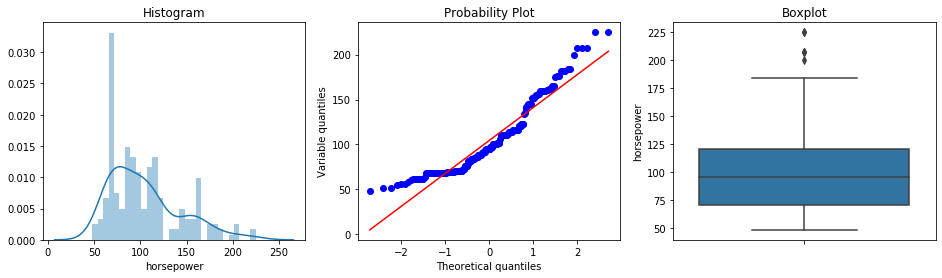

In [28]:
diagnostic_plots(data, 'horsepower')

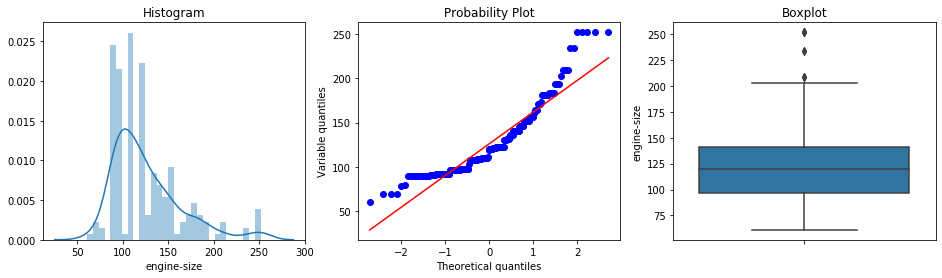

In [29]:
diagnostic_plots(data, 'engine-size')

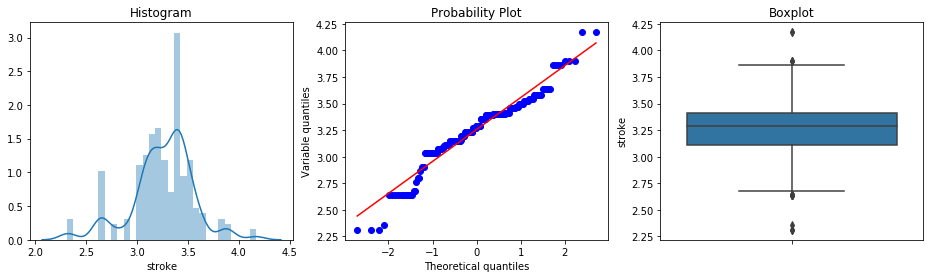

In [30]:
diagnostic_plots(data, 'stroke')

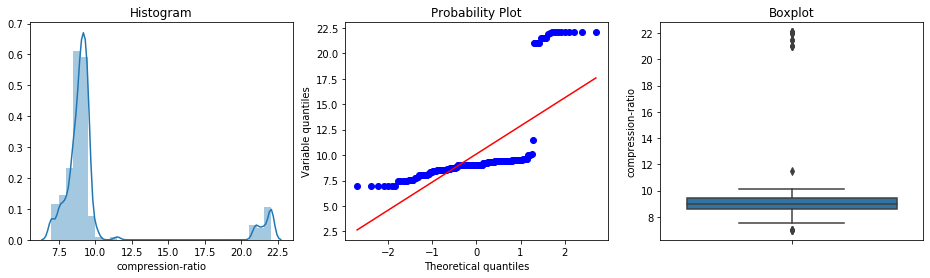

In [31]:
diagnostic_plots(data, 'compression-ratio')

None of these variables are normally distributed, that is probably why the Gaussian approximation was not so effective to remove outliers. We could try and use a smaller distance, instead of multiplying by 3 times the std, we could 2 times or 1.5. But those numbers are set arbitrarily, and do not pose much statistical sense, therefore defeating the point of using the Gaussian approximation.

If this capping does not work as desired, I recommend you use the IQR rule as we discussed in the previous notebook, or quantiles, as we will see in the next one.

## Censoring with feature-engine

In [32]:
# let's load the imports-85-clean-data.csv dataset

data = pd.read_csv('C:\\Users\\gusal\\machine learning\\Feature engineering\\automobile data set\\imports-85-clean-data.csv')


In [33]:
# create the capper

windsoriser = Winsorizer(distribution='gaussian', # choose skewed for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=features_numerical)

windsoriser.fit(data)

Winsorizer(distribution='gaussian', fold=3, tail='both',
           variables=['symboling', 'normalized-losses', 'wheel-base', 'length',
                      'width', 'height', 'curb-weight', 'engine-size', 'bore',
                      'stroke', 'compression-ratio', 'horsepower', 'peak-rpm',
                      'city-mpg', 'highway-mpg', 'price'])

In [34]:
data_t = windsoriser.transform(data)

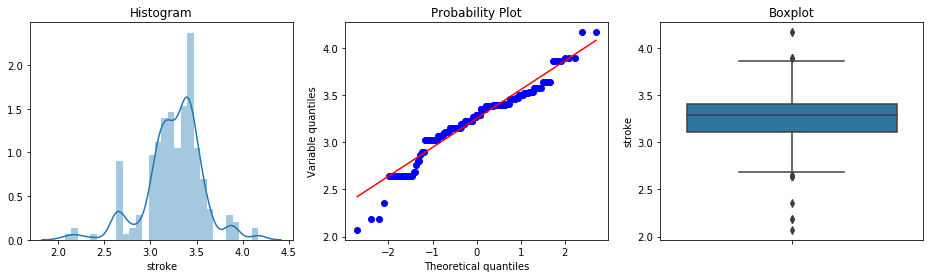

In [35]:
diagnostic_plots(data, 'stroke')

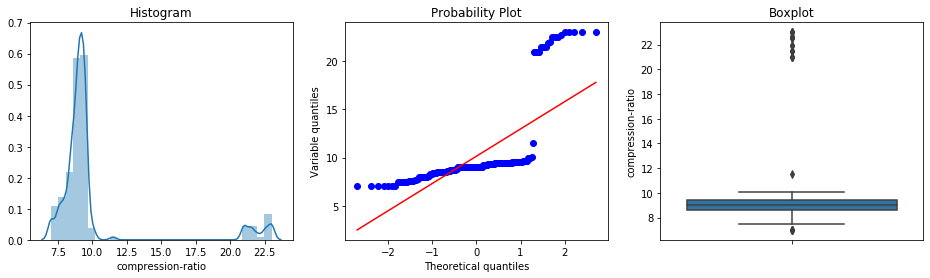

In [36]:
diagnostic_plots(data, 'compression-ratio')

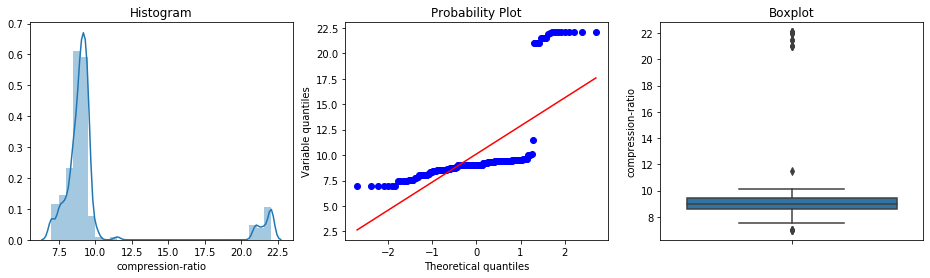

In [37]:
diagnostic_plots(data_t, 'compression-ratio')

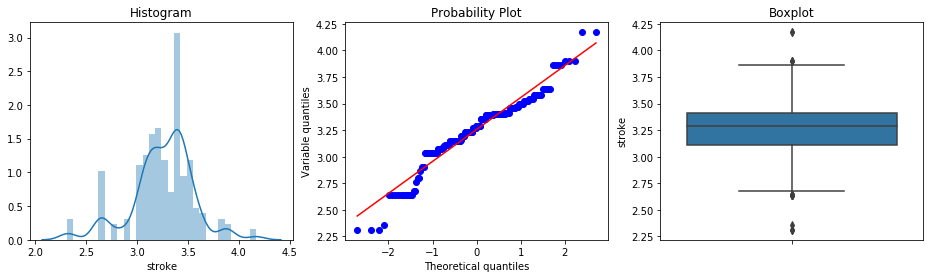

In [38]:
diagnostic_plots(data_t, 'stroke')

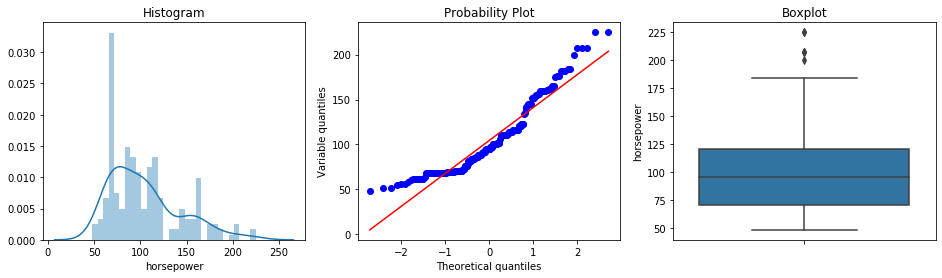

In [39]:
diagnostic_plots(data_t, 'horsepower')

In [40]:
# we can inspect the minimum caps for each variable
windsoriser.left_tail_caps_

{'symboling': -2.901774142853175,
 'normalized-losses': 12.756929200049086,
 'wheel-base': 80.69125831077707,
 'length': 137.03740271301749,
 'width': 59.472193319987205,
 'height': 46.39431213906581,
 'curb-weight': 993.5252431536201,
 'engine-size': 1.9792367586312594,
 'bore': 2.505732458639201,
 'stroke': 2.311553359183688,
 'compression-ratio': -1.7735843802240367,
 'horsepower': -15.060801660417383,
 'peak-rpm': 3694.4321785382062,
 'city-mpg': 5.593087236117093,
 'highway-mpg': 10.091890119369662,
 'price': -10966.710698292605}

In [41]:
# we can inspect the maximum caps for each variable
windsoriser.right_tail_caps_

{'symboling': 4.570066825780004,
 'normalized-losses': 244.39570570726798,
 'wheel-base': 116.82191242093049,
 'length': 211.06113387234862,
 'width': 72.34341643611029,
 'height': 61.05544395849524,
 'curb-weight': 4117.606464163453,
 'engine-size': 251.8353973877102,
 'bore': 4.144023638921778,
 'stroke': 4.195178348133373,
 'compression-ratio': 22.058657550955747,
 'horsepower': 224.75836263602713,
 'peak-rpm': 6556.306737715452,
 'city-mpg': 44.84593715412681,
 'highway-mpg': 51.410548905020576,
 'price': 37609.267943638944}

In [42]:
data_t.describe()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,128.349892,98.736692,174.049268,65.907805,53.724878,2555.565854,125.956961,3.324878,3.255730,10.109990,104.358618,5124.943182,25.187989,30.730835,13248.853276
std,1.245307,37.882200,5.954627,12.337289,2.145204,2.443522,520.680204,37.926939,0.273049,0.306015,3.869105,38.115845,475.672396,6.437992,6.821365,7847.587536
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.311553,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,95.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.130000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,125.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,154.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,120.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,244.395706,116.821912,208.100000,72.300000,59.800000,4066.000000,251.835397,3.940000,4.170000,22.058658,224.758363,6556.306738,44.845937,51.410549,37609.267944


In [43]:
data.describe()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,128.576317,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.324878,3.253366,10.142537,104.848780,5125.369458,25.219512,30.751220,13321.278623
std,1.245307,38.606463,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.273049,0.313937,3.972040,39.969861,476.979093,6.542142,6.886443,8095.996440
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,95.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.130000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,125.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,154.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,120.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


None of these variables are normally distributed, that is probably why the Gaussian approximation was not so effective to remove outliers. We could try and use a smaller distance, instead of multiplying by 3 times the std, we could 2 times or 1.5. But those numbers are set arbitrarily, and do not pose much statistical sense, therefore defeating the point of using the Gaussian approximation.

If this capping does not work as desired, I recommend you use the IQR rule as we discussed in the previous notebook, or quantiles, as we will see in the next one.